In [1]:
import os
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(0)
az.style.use("arviz-darkgrid")
%matplotlib inline

### 1. Get SP500 data

In [6]:
# !pip install yfinance

In [7]:
import yfinance as yf

In [8]:
# !pip install pandas_datareader

In [9]:
import pandas_datareader.data as web
import datetime

In [10]:
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

sp500 = web.DataReader(['sp500'], 'fred', start, end)

In [11]:
sp500.shape

(2608, 1)

In [12]:
sp500.tail()

,sp500
DATE,
2022-04-12,4397.45
2022-04-13,4446.59
2022-04-14,4392.59
2022-04-15,NaN
2022-04-18,4391.69


In [13]:
sp500.head()

,sp500
DATE,
2012-04-19,1376.92
2012-04-20,1378.53
2012-04-23,1366.94
2012-04-24,1371.97
2012-04-25,1390.69


In [14]:
df = yf.download(["spy"], start, end)
df.shape

[*********************100%***********************]  1 of 1 completed


(5610, 6)

In [15]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-11,444.109985,445.000000,439.390015,439.920013,439.920013,89770500
2022-04-12,443.079987,445.750000,436.649994,438.290009,438.290009,84363600
2022-04-13,438.029999,444.109985,437.839996,443.309998,443.309998,74070400
2022-04-14,443.549988,444.730011,437.679993,437.790009,437.790009,97720700
2022-04-18,436.809998,439.750000,435.609985,437.970001,437.970001,65798700


In [16]:
sp500["change"] = np.log(sp500["sp500"]).diff()

In [17]:
sp500.isna().sum()

sp500      92
change    184
dtype: int64

In [18]:
sp500 = sp500.dropna()

In [34]:
sp500.to_csv("../data/sp500.csv")

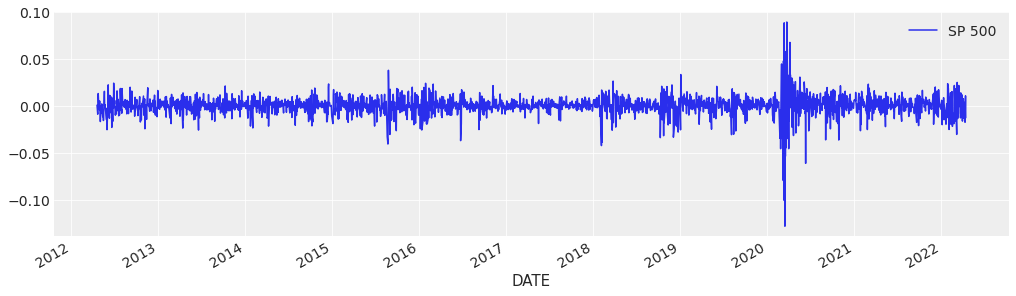

In [19]:
# Plot data
fig, ax = plt.subplots(figsize=(14,4))
sp500.plot(y="change", label="SP 500", ax=ax);

### Model

In [22]:
len(sp500.index.values)

2424

In [25]:
with pm.Model(coords={"time": sp500.index.values}) as model:
    step_size = pm.Exponential("step_size", 10)
    volatility = pm.GaussianRandomWalk('volatility', sigma=step_size, dims="time")
    nu = pm.Exponential("nu", 0.1)
    returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2*volatility), observed=sp500["change"])

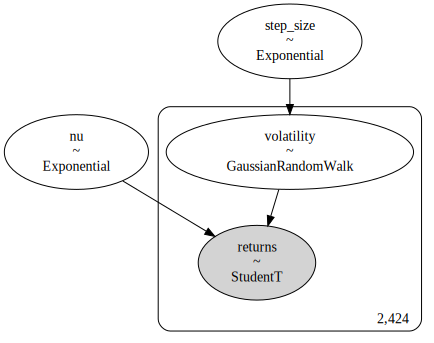

In [26]:
pm.model_to_graphviz(model)

In [27]:
with model:
    trace = az.from_pymc3(prior=pm.sample_prior_predictive(1000))

In [28]:
prior_predictive = trace.prior_predictive.stack(pooled_chain=("chain", "draw"))

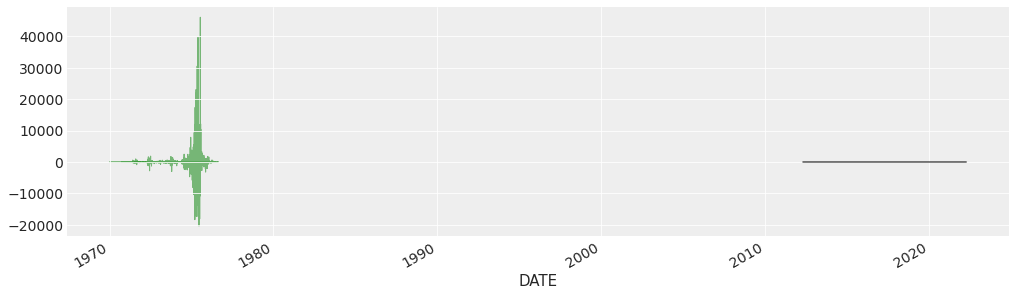

In [30]:
fig, ax = plt.subplots(figsize=(14, 4))
sp500["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

# max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
#     np.abs(prior_predictive["returns"].values)
# )
# ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

### Fit Model

In [31]:
with model:
    trace = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, volatility, step_size]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 147 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [32]:
ppc = trace.posterior.stack(pooled_chain=("chain", "draw"))
ppc["exp_volatility"] = np.exp(ppc["volatility"])

In [33]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

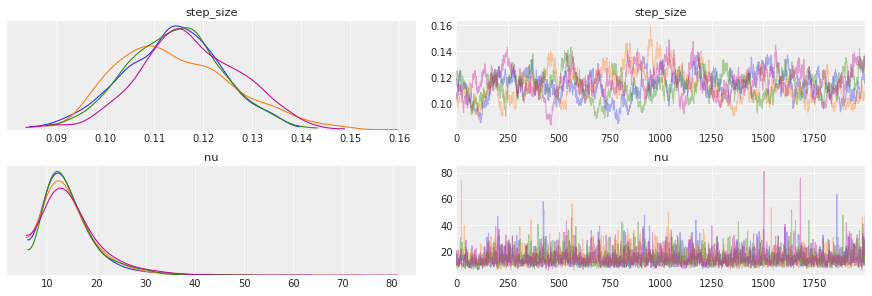

In [29]:
az.plot_trace(trace, var_names=["step_size", "nu"]);

### Posterior predictive check

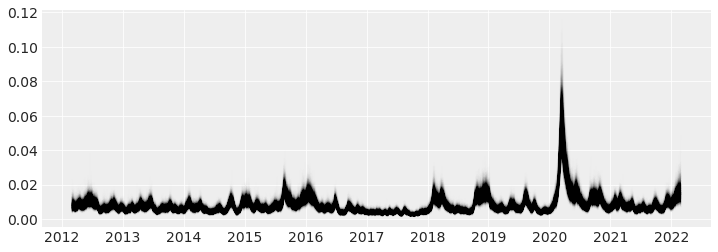

In [31]:
fig, ax = plt.subplots(figsize=(12,4))
y_vals = ppc["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = pd.to_datetime(sp500.index)

plt.plot(x_vals, y_vals, "k", alpha=0.002);

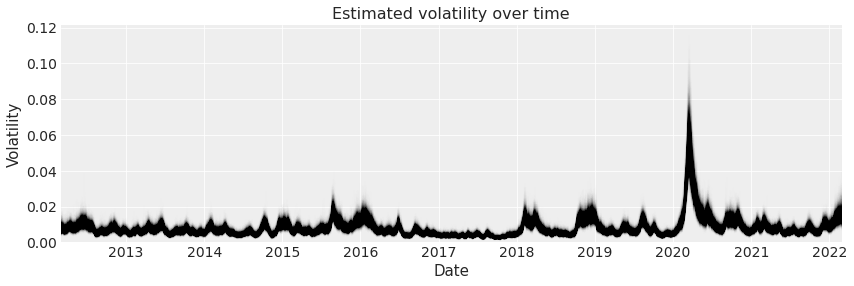

In [32]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = ppc["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = pd.to_datetime(sp500.index)#y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

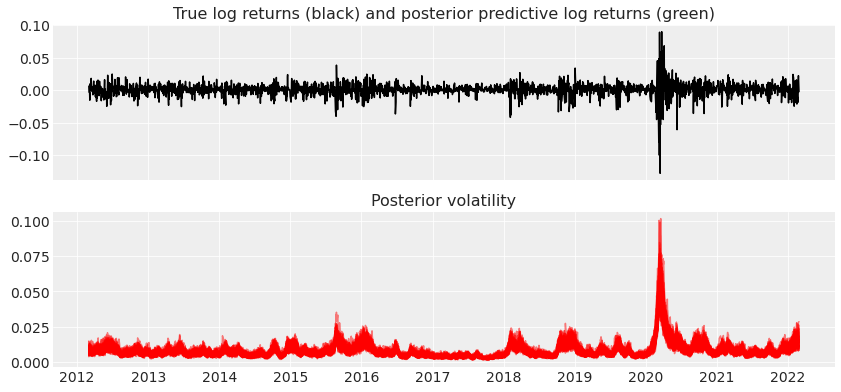

In [34]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
sp500["change"].plot(ax=axes[0], color="black")

axes[1].plot(x_vals, ppc["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
# axes[0].plot(
#     x_vals,
#     ppc["returns"].isel(pooled_chain=slice(None, None, 100)),
#     "g",
#     alpha=0.5,
#     zorder=-10,
# )
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");